### An Introduction to Value At Risk

#### Introduction

Let $X$ be a random variable describing our financial position,
so that higher values of $X$ represent convenient outcomes.
When modeling the *risk* of $X$,
a quick description is generally offered by the standard variation $\sigma(X)$, 
since it determines how far the samples can differ from the expected value
(Chebyshev inequality).

But when dealing with Financial risk, this notion reveals its limitations:
there is indeed a greater interest in predicting unexpected losses, 
*unfavorable* outcomes, while the variance does not differentiate
between "positive" or "negative" events
(due to its squared difference in the definition),
motivating the search for other techniques.

#### Monetary Risk Measures
The literature is vast and offers dozens of definitions,
each with pros and cons, as for instance described in the
book *Stochastic Finance* (Follmer).

If we indicate by $\rho :  \mathbb{R} \to \mathbb{R}$ a generic function,
candidate to measure the "risk", with three properties are commonly required:

- *risk minimization*: lower values of $\rho(X)$ indicate
        more "convenient" scenarios;
 - *monotonicity*: if $X \leq Y$, then $\rho(Y) \leq \rho(X)$;
 - *cash-invariance*: for each $m \in \mathbb{R}$, we have 
        $\rho(X + m) = \rho(X) - m$;

Monotonicity simply means that if the financial position $Y$ always ensures
a better gain than $X$, then the risk of $Y$ is lower.
Cash-invariance is interpreted as if we had more money $m$ at
disposal when getting a position $X$, the overall risk would reduce since that
capital could be used to countereffect possible negative outcomes
(e.g. avoiding bankrupt).

Any position $X$ is called *acceptable* if and only if $\rho(X) \leq 0$.

A function $\rho$ satisfying the properties above is called
*monetary risk measure*, and has the advantage of offering the following
clear interpretation.

Proposition: The quantity $\rho(X)$ is the smallest amount of money that,
when added to the position $X$, makes it acceptable.

Proof: For any $m \geq \rho(X)$ we have
$\rho(X + m) = \rho(X) - m \leq \rho(X) - \rho(X) = 0$, therefore the position
is accepted. 
The converse holds for any $m < \rho(X)$.

//

#### Quantiles of a random variable

This section is on a first sight independent from the part above,
but the two topics will merge later when discussing the Value At Risk.

Let $X$ be a real random variable.
The comulative distribution function 
$F_X: \mathbb{R} \to [0,1]$
of $X$ is defined as $F_X(t) = P[X \leq t ]$.

Generally speaking, the map above is non-decreasing 
and continuos from the right,
but for simplicity we assume strict monotonicity and full continuity.

Under these conditions, it is possible to easily define
the quantile function as the inverse map
$Q_X: [0,1] \to \mathbb{R}$, with $Q_X(p) = F^{-1}(p) = t$, 
being $t$ the only value such that $P[X \leq t] = p$.

Quantile represents a very strong tool to study probability distributions
and can be generalized to less regular cases.

Proposition: The two following properties hold:
 - for every $m \in \mathbb{R}$ and
      $p \in [0,1]$, we have $Q_{X+m}(p) = Q_{X}(p) + m$;
 - if $X \leq Y$, then $Q(X) \leq Q(Y)$.


Proof:
The former property follows by explicitely writing the quantile definition
on both sides. The latter holds since $X \leq Y$ implies
$P[X \leq k] \geq P[Y \leq k]$. Replacing $k$ with the
corresponding quantiles concludes the proof.

//

We close this section by proposing a way to approximate quantiles
from a computational viewpoint.
Let's suppose to have $N$ samples from a continuous random variable $X$,
and interest in approximating its $p$ quantile,
i.e. the value $Q(p)$ such that $P[X \leq Q(p)] = p$.
An approximation can be chosen between the available samples
as follows:

 - sort all the samples (assumed all different)
 $X_0, \dots, X_{N-1}$ in ascending oder;
 - take $k = floor(N p)$ (Recall: the floor operation approximates to
       the imediate previous integer, e.g. floor(3.7) = 3);
 - if $k \geq 1$, then we take as approximated quantile the number
       $X_{k-1}$ (more explanation follows).
       Otherwise we can only claim that the quantile is stricly
       inferior than $X_0$.
      We return $X_0$, but with an attached warning message.


Observing that for any $x \in \mathbb{R}$ we have
$floor(x) \leq x < floor(x) + 1$, and since the samples are sorted
with indeces starting from $0$, the following holds:
 - $P[X \leq X_{k-1}] = \frac{k}{N} = 
        \frac{floor(N p)}{N} \leq \frac{Np}{N} = p$
 - $P[X \leq X_{k}] = \frac{k+1}{N} =
       \frac{floor(Np) + 1}{N}> \frac{Np}{N} = p$


Therefore, on the base of the empirical samples,
the true quantile satisfying
$P[X \leq Q(p)] = p$ must lie in the interval
$[X_{k-1}, X_{k})$.

For simplicity we return the value $X_{k-1}$.
The following code implements these ideas.

In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def get_quantile (given_samples : np.array, p : float,
                            verbose : bool = True) -> float:
    '''
    The array given_samples contains the samples (real numbers), while
    p is the target probability strictly between 0 and 1.
    The function returns a quantile estimation according to the sorting
    strategy.
    '''
    assert(p > 0. and p < 1.)
    # Sort samples in ascending order
    samples = np.sort(given_samples.reshape(-1,))
    n_samples = samples.shape[0]
    assert(n_samples >= 2)
    # Check that all the samples are different, as it must happen for
    # correctly approximated continuous distributions
    for nth in range(n_samples - 1):
        if samples[nth] == samples[nth + 1]:
            print("*WARNING: get_quantile detected samples with same values!")
            print(" ---! Are you sure your variable is continuous?")
    # Convert the probability p into "how many elements" 
    # from the sorted samples has to be taken until reaching p.
    # Example: if the samples are 100 sorted number, 
    # take the first 80 to realize the 80% quantile.
    idx_low = int(np.floor(n_samples * p))
    if idx_low == 0:
        print(f"Quantile {p} is too small for num samples {n_samples}")
        return samples[0]
    # this is the "k" in the notation above
    idx_up = int(idx_low)
    # and "k-1" is the index idx_low
    idx_low = idx_up - 1
    # q_low is the lower bound in the interval, while...
    q_low = samples[idx_low]
    # q_up is the upper bound.
    q_up = samples[idx_up]
    # Double check that the two elements approximate the desired quantile
    p_low = np.sum(samples <= q_low) / n_samples
    p_up = np.sum(samples <= q_up) / n_samples
    # We must have: p_low <= p, and p_up > p.
    if not ((p_low <= p) and (p_up > p)):
        # I will replace assert with raise/error in case of need
        print(f"Fatal error:")
        print(f"{p_low} > {p} or {p_up} <= {p}")
        assert False
        
    if verbose:
        print(f"From get_quantile:")
        print(f"\t{p*100:.3f}%-quantile in [{q_low:.3e}, {q_up:.3e})")
        print(f"\t{p*100:.3f}%-quantile is {q_low:.3e}") 
        print(f"\tP [X <= {q_low :.3e}] = {p_low : .3e} <= {p : .3e}")
        print(f"\tP [X <= {q_up:.3e}] = {p_up : .3e} > {p : .3e}")
        print("-")
    return q_low
#---

In [3]:
def error_analysis(true_value, p):
        '''
        Perform an error analysis for the get_quantile
        function, based on the known quantile values for the normal
        distribution.
        '''
        n_exponents = 5
        base = 5
        exponents = range(base, base + n_exponents)
        mean_errors = []
        for power in exponents:
                n_simulations = 100
                n_samples = int(math.pow(2., power))
                simu_errors = np.zeros(n_simulations)
                for nth_simu in range(n_simulations):
                        samples = np.random.normal(0., 1., (n_samples,)) 
                        result = get_quantile(samples, p, verbose = False)
                        tmp = np.abs(true_value - result)
                        # choose relative errors
#                        simu_errors[nth_simu] = tmp * 100. / np.abs(true_value)
                        # or choose absolute errors
                        simu_errors[nth_simu] = tmp
                mean_errors.append(simu_errors.mean())
        return (exponents, mean_errors)
#----

In [4]:
err_1, res_1 = error_analysis(1.6449, 0.95)
err_2, res_2 = error_analysis(-0.8416, 0.20)
err_3, res_3 = error_analysis(0., 0.50)
err_4, res_4 = error_analysis(-1.96, 0.025)

Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.02

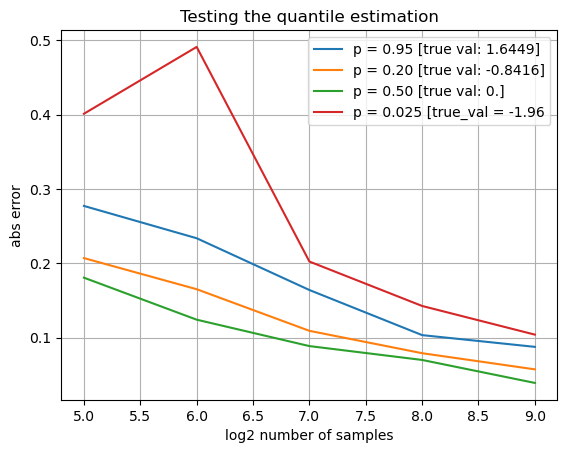

In [5]:
# Plot the results to see how the approximation improves when the number
# of available samples increases. Note how for very small quantiles,
# like 0.025, there is initially a bigger error: this is because the number of 
# samples is initially too small to determine such a small probability value.
plt.plot(err_1, res_1, label = "p = 0.95 [true val: 1.6449]")
plt.plot(err_2, res_2, label = "p = 0.20 [true val: -0.8416]")
plt.plot(err_3, res_3, label = "p = 0.50 [true val: 0.]")
plt.plot(err_4, res_4, label = "p = 0.025 [true_val = -1.96")
plt.grid()
plt.title("Testing the quantile estimation")
plt.xlabel("log2 number of samples")
plt.ylabel("abs error")
plt.legend()
plt.show()

#### Value At Risk: a Monetary Risk Measure based on Quantiles


We now introduce a monetary risk measure based on the notion of quantile.

For a financial position $X$, the *Value At Risk* is the map
$V_@R(X): [0, 1] \to \mathbb{R}$
defined as:

$V_@R_\lambda(X) = - Q_X(\lambda)$, for $\lambda \in [0,1]$

Proposition: The Value At Risk is a monetary risk measure.

Proof:
This is a direct consequence of the properties shown in the section above.
For $X \leq Y$ we have $Q_X \leq Q_Y$ and therefore
$V_@R(X) \geq V_@R(Y)$.
The cash-invariance property follows from the quantile translational invariance:

$V_@R_\lambda(X + k) =
        - Q_{(X + k)}(\lambda) = 
        - Q_X(\lambda) - k =
        V_@R_\lambda(X) - k
$

//

The next goal is to develop more intuition about how to interpret the
value at risk. Directly by its definition we have:

$P [ X + V_@R_\lambda(X) \leq 0] = \lambda$

Therefore $V_@R$ can here be read as an amount of money that, if added to
$X$, would make negative or zero outcomes stay controlled under a probabiility
$\lambda$ (chosen usually very small, for instance around $0.05$).

Note that if the financial position $X$ is acceptable, 
i.e. $\rho(X) = V_@R(X) \leq 0$,
then there is no need to add any further capital:
the random events already distributes the desired probability treshold.

On the other hand, if $X$ is not acceptable,
since $V_@R$ is a monetary risk measure,
the quantity $V_@R(X)$ would actually represent the *minimal* amount of money 
needed to be added to
$X$ to make it acceptable, i.e. to control the overall probability of loss
by the probability $\lambda$.

There is no further remark on the computational aspect of this risk indicator,
since it would be enough to use the algorithm proposed for the quantile
in the section before.

In [6]:
def get_var (given_samples, prob, verbose = False):
        """ Compute the Value At Risk for a continuous distribution
        using its interpretation as quantile"""
        return - get_quantile(given_samples, prob, verbose)

In [7]:
def test_var ():
        """
        Testing the Value At Risk routine against
        known values for the exponential distribution
        """
        chosen_p = 0.95
        scales = [2.0, 5.0, 10.]
        for scale in scales:
                samples = np.random.exponential(scale, (10_000,1))
                true_var = scale * np.log(1. - chosen_p)
                approx_var = get_var(samples, chosen_p, verbose = False)
                print(f"True: {true_var : .3f} Approx: {approx_var : .3f}")
#---

In [8]:
print(f"Computing different VaR for the exponential distribution")
test_var()

Computing different VaR for the exponential distribution
True: -5.991 Approx: -6.149
True: -14.979 Approx: -15.318
True: -29.957 Approx: -30.425


#### Final remarks

The definition of Value At Risk can be surprisingly ambiguous if one
searches between different resources.
We point out how in out intepretations, $V_@R_\lambda(X)$
enjoys the following:
 - the variable $X$ is assumed to have a continuos probability
        distribution (we did not discuss the discrete case);
 - when commenting quantiles, our inequalities were always not strict,
        in the sense that we accepted $P[X \leq t]$. Sometimes a strict
        "$<$" is used, esxpecially in the discrete case, with a direct
        impact on the Value At Risk;
 - our parameter $\lambda$ is understood in a way that "the lower,
        the safer we are trying to be". Sometimes the $V_@R$ is alternatively
        defined with respect to a "confience level" $c = 1 - \lambda$,
        therefore such that "the higher, the better";
 - more refined algorithms to approximate quantiles exist.

#### Conclusion

In this notebook we introduced the notion of Value At Risk, interpreted
as the minimal amount of additional money needed to control losses below some
probability treshold.
The definition originates from the idea of quantile,
and is obtained after some modification until satisfying the axioms 
needed from the defition of formal monetary risk measure.

A simple approximating algorithm is proposed and tested.

#### Ideas for further notebook:
 - $X$ is now a Financial Stochastic Process. Evaluate VaR;
 - samples of $X$ are taken from our internal Datenbank (Azure...);
 - comparison between different ways to compute VaR;
 - Portfolio class, with VaR method...?